In [3]:
from robot import *

In [4]:
class PsiCamera(Camera):
    def data(self, cam_pose, orientation_noise=math.pi / 90):
        observed = []
        for lm in self.map.landmarks:
            psi = norm.rvs(loc=math.atan2(cam_pose[1] - lm.pos[1], cam_pose[0] - lm.pos[0]), scale=orientation_noise)
            z = self.observation_function(cam_pose, lm.pos)
            z = self.phantom(cam_pose, z)
            z = self.oversight(z)
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append(([z[0], z[1], psi], lm.id))
        
        self.last_data = observed
        return observed

In [5]:
class LoggerAgent(Agent):
    def __init__(self, nu, omega, interval_time, init_pose):
        super().__init__(nu, omega)
        self.interval_time = interval_time
        self.pose = init_pose
        self.step = 0
        self.log = open('log2.txt', 'w')
        self.log.write("delta {}\n".format(interval_time))
    
    def decision(self, observation):
        self.log.write("u {} {} {}\n".format(self.step, self.nu, self.omega))
        self.log.write("x {} {} {} {}\n".format(self.step, *self.pose))
        for obs in observation:
            self.log.write("z {} {} {} {} {}\n".format(self.step, obs[1], *obs[0]))
            
        self.step += 1
        self.log.flush()
        
        self.pose = IdealRobot.state_transition(self.nu, self.omega, self.interval_time, self.pose)
        return self.nu, self.omega

<IPython.core.display.Javascript object>


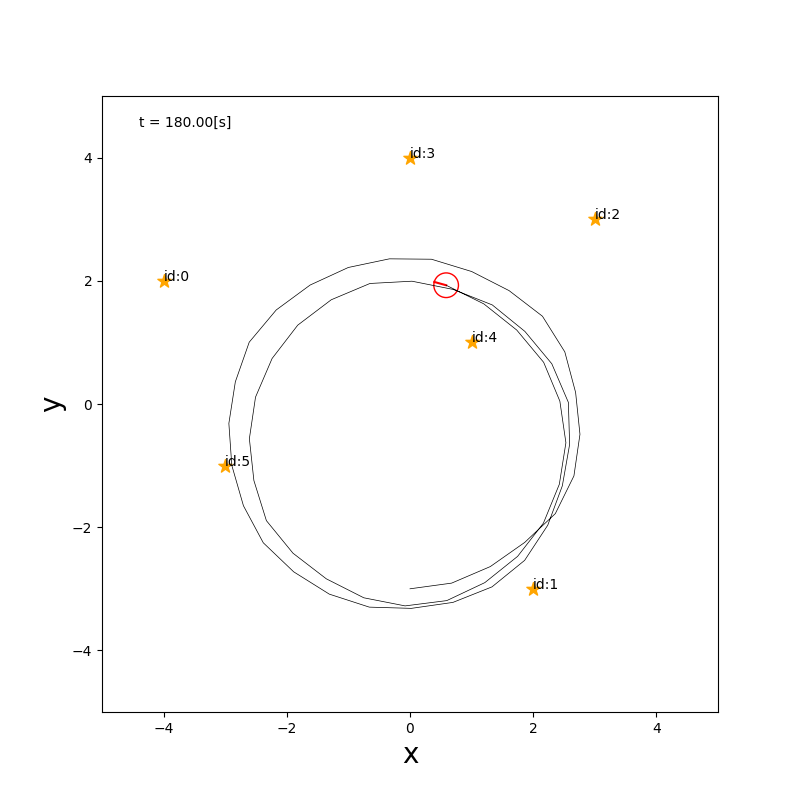

In [6]:
time_interval = 3
world = World(180, time_interval, debug=False)

m = Map()
landmark_positions = [(-4, 2), (2, -3), (3, 3), (0, 4), (1, 1), (-3, -1)]
for p in landmark_positions:
    m.append_landmark(Landmark(*p))

world.append(m)

init_pose = np.array([0, -3, 0]).T
a = LoggerAgent(0.2, 5.0 / 180 * math.pi, time_interval, init_pose)
r = Robot(init_pose, sensor=PsiCamera(m), agent=a, color='red')
world.append(r)

world.draw()